<a href="https://colab.research.google.com/github/jhdavislab/wqbio2022/blob/main/wqbio2022_cryoem_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing our required libraries

In [1]:
!pip install mrcfile

     |████████████████████████████████| 40 kB 8.7 kB/s 


In [2]:
import mrcfile as mrcf
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining a few plotting parameters

In [4]:
#####################################################
figsize = (8,8) #set this appropriately based on your screen size - 8,8 works well on a laptop

ang_px = 0.6575 #this was the pixel size used in the microscope...crazy, right?
proteasome_length_ang = 150 #this is approxiamately the length of the proteasome in angstroms
proteasome_length_px = proteasome_length_ang/ang_px #this is the length in pixels
######################################################

## Defining a few useful functions to plot our images
* Time permitting, you can read through this function, but it is not critical for this module.
 * *If you do take the time, think about why we set the vmin and vmax the way we do - hint: try plotting a histogram of the pixel values in one of our images to think about why we need to narrow the range to see our images*

In [5]:
def plot_micrograph(img, figsize=figsize, axis=False, crange=2, ax=None):
    if ax is None:
      f, ax = plt.subplots(1,1, figsize=figsize)
    img_mean = img.mean()
    img_std = img.std()
    ax.imshow(img, cmap='gray', origin='lower', vmin=img_mean-crange*img_std, vmax=img_mean+crange*img_std)
    if not axis:
        ax.axis('off')
    return ax

## Manipulating images in Fourier space
* We'll start with a full resolution micrograph (summed without any motion correction) so that we have enough signal to see [Thon rings](https://cryoem101.org/chapter-5/#part3) in Fourier space.

* For simplicity, we've made the image square - **How was that in the code below done?**

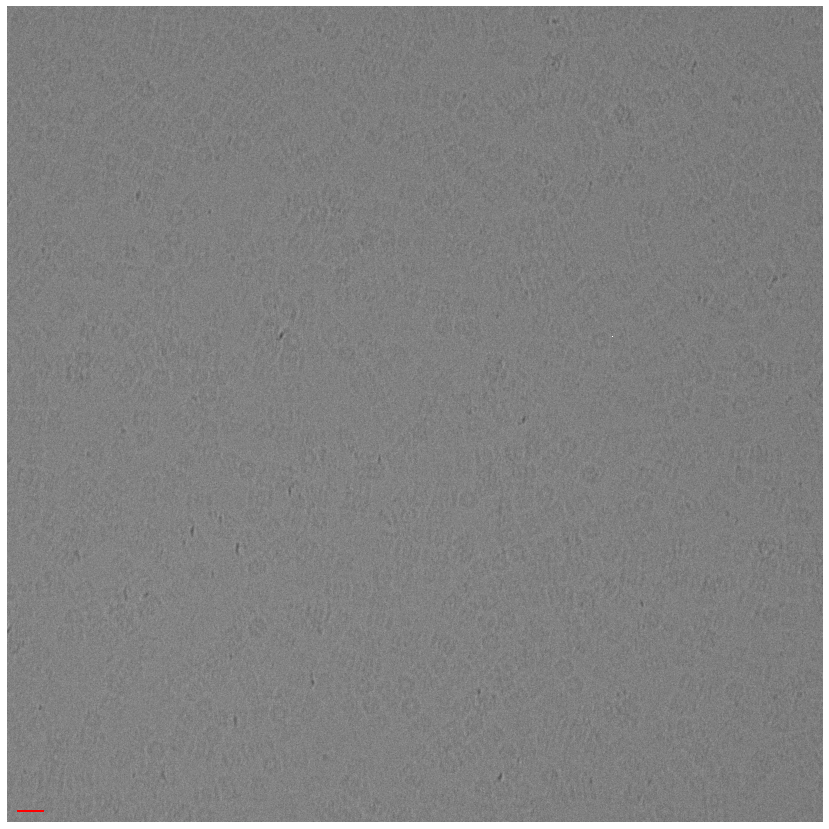

In [6]:
summed_micrograph = mrcf.open('/content/drive/My Drive/qmw_cryoem_data/summed_movie.mrc').data[:7420, :7420]
summed_micrograph.shape
ax = plot_micrograph(summed_micrograph, figsize=(15,15))
ax.plot([100,100+proteasome_length_px], [100,100], color='red', linewidth=2)

## Defining Fourier transform functions
* For convience, I've defined a few useful Fourier transform operations - you don't need to understand the details of these functions, but I want you to get the following main ideas: 
 * the Fourier transform of our image contains ALL of the information of the original image, but it has been decomposed into frequency components, which allows us to independently module high frequency (think rapid oscilations between white and black) and low frequency (think large blocks of white or black, like you might see in a particle) components
 * the power spectra we are plotting is the magnitude of the Fourier components - this tells how much of each component is in our image. If we see large values in the region of the poewr spectra corresponding high frequency information, that says there is lots of high frequency info in our image.
 * we often shift the power spectra such that the loweset frequency components are near the middle of the image, and the highest frequency compnents at the periphery.

In [7]:
#compute the Fourier transform and center it
def fft_center(img):
  f = np.fft.fft2(img) #this calculates the FT of our image - note that it is a complex output with real and imaginary components
  return np.fft.fftshift(f) #this shifts the origin to the center of the image

#shift the origin back away from the center and compute the inverse Fourier transform, return the real portion
def inv_fft(fft_cent):
  fft_shift = np.fft.ifftshift(fft_cent) #this shifts the center of the image back to the origin
  img = np.fft.ifft2(fft_shift) #this calculates the inverse FT
  return img.real

#calculate a power spectra given a centered Fourier transformed image
def ps_center(fft_cent):
  ps = np.abs(fft_cent)**2 #this line calculates the power spectra, which is the magnitude of the FT
  return np.log(ps) #we take the log to better visualize the small amplitude components.

* We'll first compute our power spectra, then plot it.

 **What do you notice about the power spectra?**

 **Are all frequency components equally represented in this micrograph?**

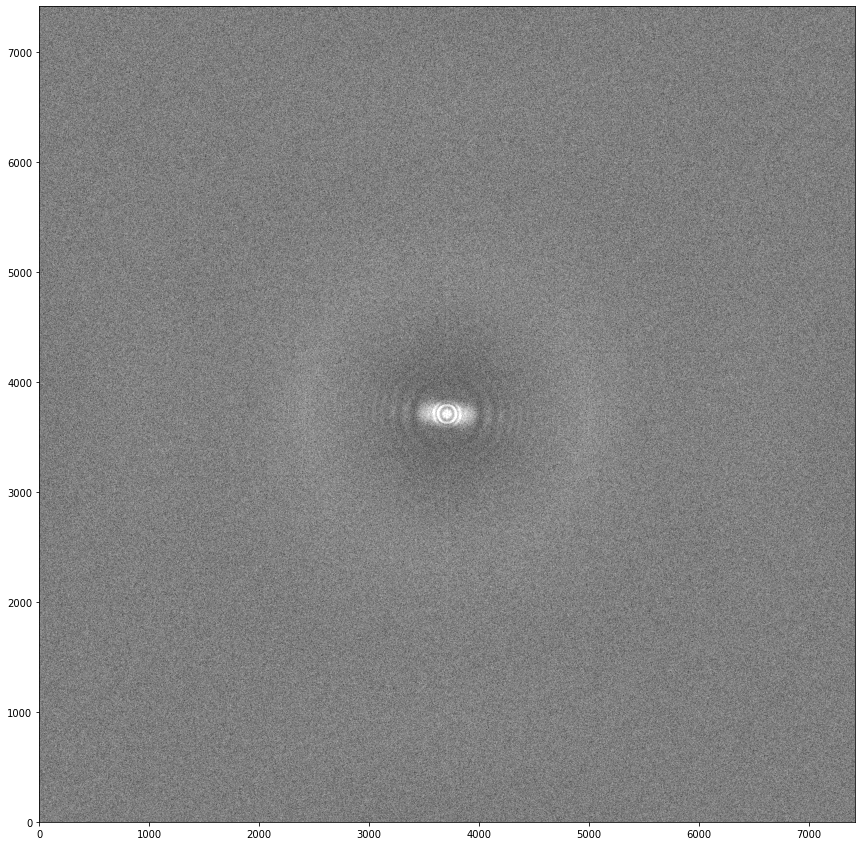

In [8]:
fft_cent = fft_center(summed_micrograph)
ps = ps_center(fft_cent)
ax = plot_micrograph(ps, figsize=(15,15), axis=True, crange=1)

**In the above image, are low frequency or high frequency components more strongly represented? Can you hypothesize a couple of reasons why that might occur when imaging a biological sample?**

Let's now compute the inverse Fourier transform and compare the resulting image to our original image

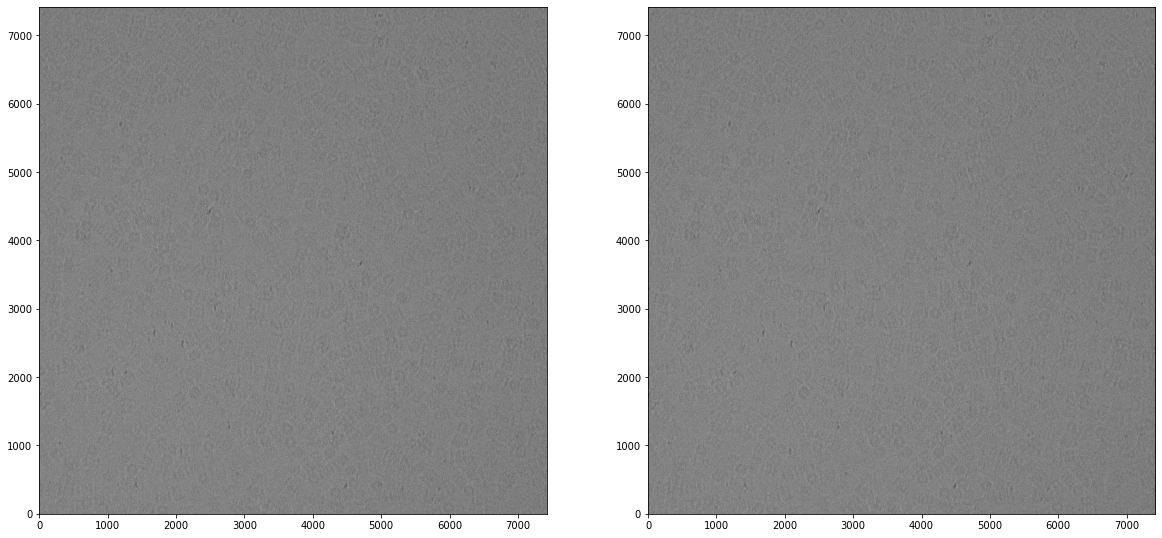

In [9]:
recovered_imag_sum = inv_fft(fft_center(summed_micrograph))
f, axes = plt.subplots(1,2,figsize=(20,10))
plot_micrograph(summed_micrograph, axis=True, ax=axes[0], crange=2)
plot_micrograph(recovered_imag_sum, axis=True, ax=axes[1], crange=2)

Great, so we can switch back and forth between these two representations of our data!

**Why might it be useful to look at the image in Fourier space?**

Let's start by looking closely at the low frequency components of our image.

## Fourier filtering

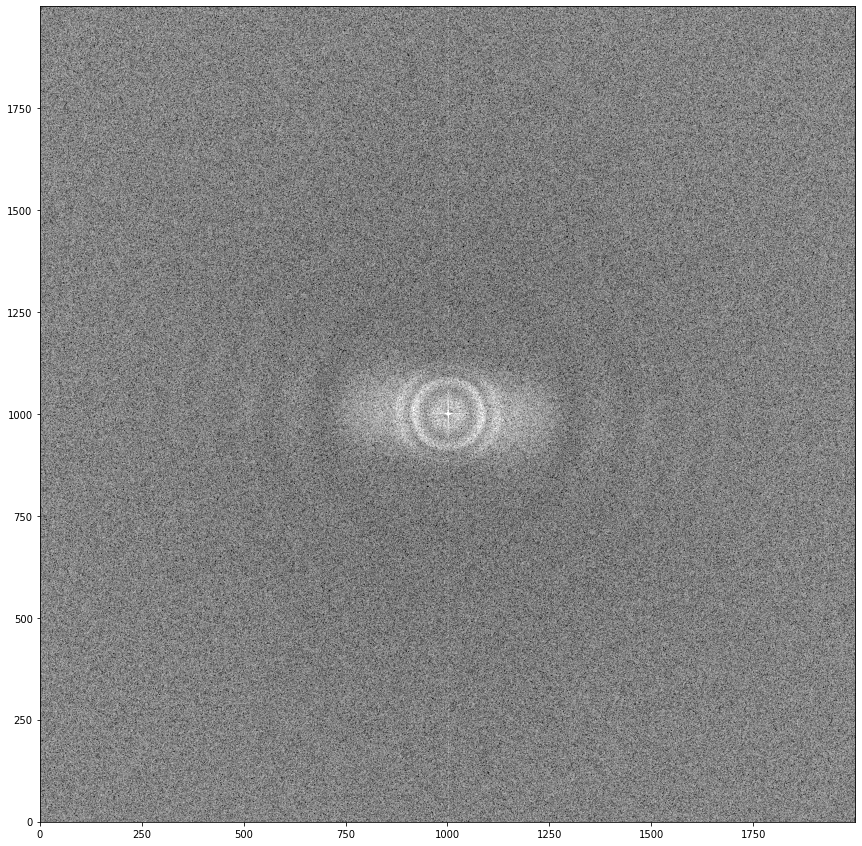

In [10]:
full_width = ps.shape[0]
zoom_range = 2000
window_low = int((full_width-zoom_range)/2)
window_high = int((full_width+zoom_range)/2)
plot_micrograph(ps[window_low:window_high,window_low:window_high], figsize=(15,15), axis=True, crange=2) #think about how I am "zooming" in on my region of interest

**What do you think would happen if we only used the information in this region of the fourier transform in our image?**

**How might one implement that?**
 * *Hint: only consider the region of the power spectra you want to use when you convert back to real space.*

**What are the dimensions of the new image?**
 * *Hint: you can use the .shape command to get the shape of your new array*

**What does it mean that our real space image has changed sizes?**
 * *Did we crop the image (i.e. just remove the outside of the real space image or do something else? If we did something else, what was it?*

(2000, 2000)
(7420, 7420)


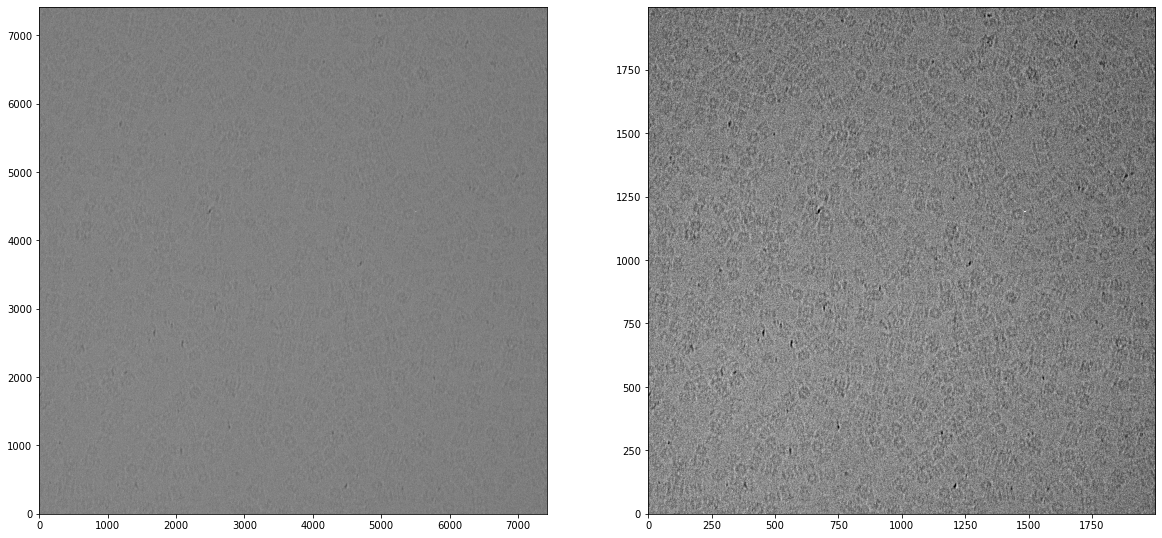

In [17]:
#Fill me in
#select the region of fft_cent you want by slicing the numpy array
#use our inv_fft function to calculate the inverse fft of that cropped image, save this as recovered_image_ft_crop
#now use our plot_micrograph function to look at the original and cropped image


#######################################################################################
#SOLUTION#
#recovered_image_ft_crop = inv_fft(fft_cent[window_low:window_high,window_low:window_high])
#print(recovered_image_ft_crop.shape)
#print(summed_micrograph.shape)
#f, axes = plt.subplots(1,2,figsize=(20,10))
#plot_micrograph(summed_micrograph, axis=True, ax=axes[0], crange=2)
#plot_micrograph(recovered_image_ft_crop, axis=True, ax=axes[1], crange=2)
#######################################################################################

**Take a moment to think carefully about why you can now see the particles more easily. What is it about the low frequency components that helps us see the outlines of the particles?**

This seems great - we've made it easier to see our particles, but we've also made our images smaller in size. Let's think about how we could accentuate the particles without changing the image size.

*Hint: What happens if we multiple a pixel in Fourier space by 0? What happens if we multiply a pixel in Fourier space by 1?*

**First, create a numpy array the same size as our original image filled with all 0s.**

**Next, define a square in the center of this array with sides of length 2000, and set those values to 1. Plot this image to make sure you are happy with your mask.**

**Finally, apply this mask to Fourier representation of our image my simply multiplying the it by the mask. Then convert the image back to real space to be visualized**

In [19]:
#Step 1 - define the numpy array for the mask with all zeros
#FILL ME IN

#######################################################################################
#SOLUTION#
#dim = summed_micrograph.shape[0]
#mask = np.zeros((dim,dim))
#######################################################################################

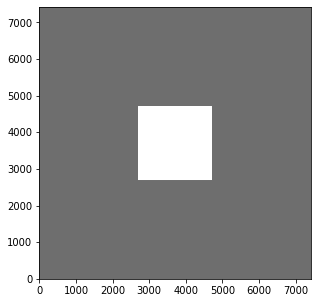

In [20]:
#Step 2 - change the inner box of the masks to 1s
#FILL ME IN

#######################################################################################
#SOLUTION#
#zoom_range = 2000
#window_low = int((dim-zoom_range)/2)
#window_high = int((dim+zoom_range)/2)
#mask[window_low:window_high,window_low:window_high] = 1
#plot_micrograph(mask[:,:], figsize=(5,5), axis=True)
#######################################################################################

**When we apply this mask, which regions will be retained, which will be lost?**
**Are we saving high frequency information or low frequency information?**

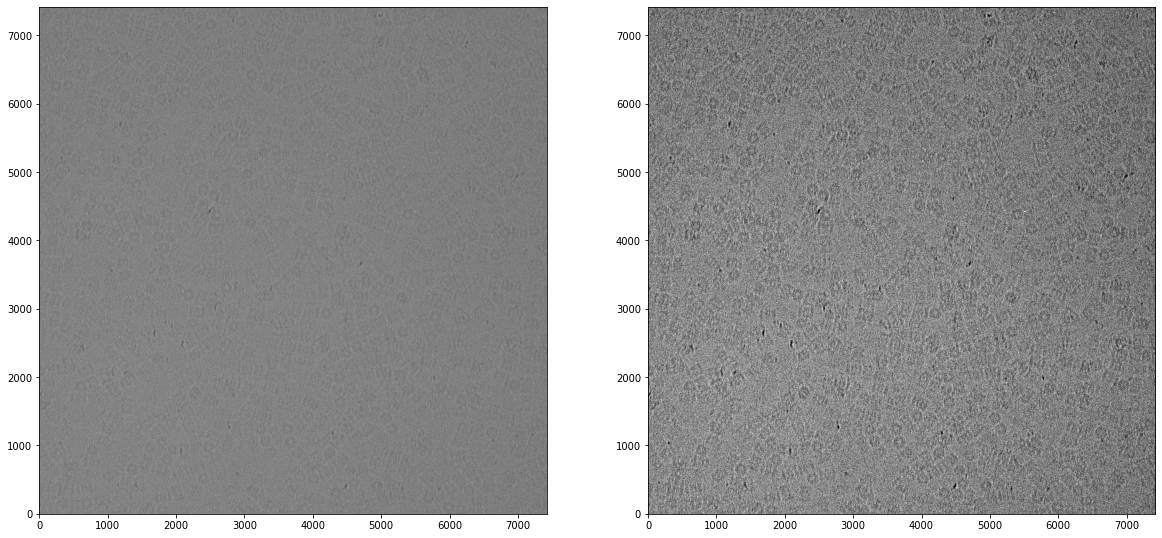

In [21]:
#Step 3 - apply the mask (by multiplying the mask with the fft_cent) and visualize the resulting image in Fourier space and in real space
#FILL ME IN

#######################################################################################
#SOLUTION#
#masked_fft = fft_cent*mask

#recovered_image_lowpass = inv_fft(masked_fft)
#f, axes = plt.subplots(1,2,figsize=(20,10))
#plot_micrograph(summed_micrograph, axis=True, ax=axes[0], crange=2)
#plot_micrograph(recovered_image_lowpass, axis=True, ax=axes[1], crange=2)
#######################################################################################

* We can see how the high frequency information is lost with this proceedure more clearly if we zoom in on a region.
* **Describe what you observe, and how this makes sense based on what we've done thus far**

**Having performed this filtering, are we able to reconstruct our original image? If not, what structural features of the proteasome might be lost in our final reconstructions?**
 * *Hint: Think about side chains, secondary structure, protein folds, domain structure*

In [16]:
f, axes = plt.subplots(1,2,figsize=(20,10))
plot_micrograph(summed_micrograph[0:250, 0:250], axis=True, ax=axes[0], crange=4)
plot_micrograph(recovered_image_lowpass[0:250, 0:250], axis=True, ax=axes[1], crange=4)

Huzzah! We've now eliminated the high frequency components in this image but maintained the original image size. We have "low-pass" filtered the image by allowing all frequencies lower than our cuttoff pass through, and all frequencies higher than this value are set to zero.

**Can you calculate the approximate size features that were passed through?**

 *Hint - it will be a function of our pixel size, and the ratio of the size of the box we cropped with relative to the original image size*
 * You'll see in the cryoSPARC demo, that low-pass filtering is also used to help visualize particles. They recommend a ~10A filter. What size box in our mask would we need to get that result?

**Below, you can optionally refilter your images at ~10A**

In [22]:
#Optionally fill me in to calculate the low-pass cuttoff in angstroms

#######################################################################################
#SOLUTION#
#low_pass = dim/zoom_range*ang_px
#print(round(low_pass,3))
#######################################################################################

2.439


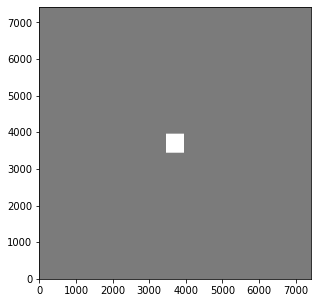

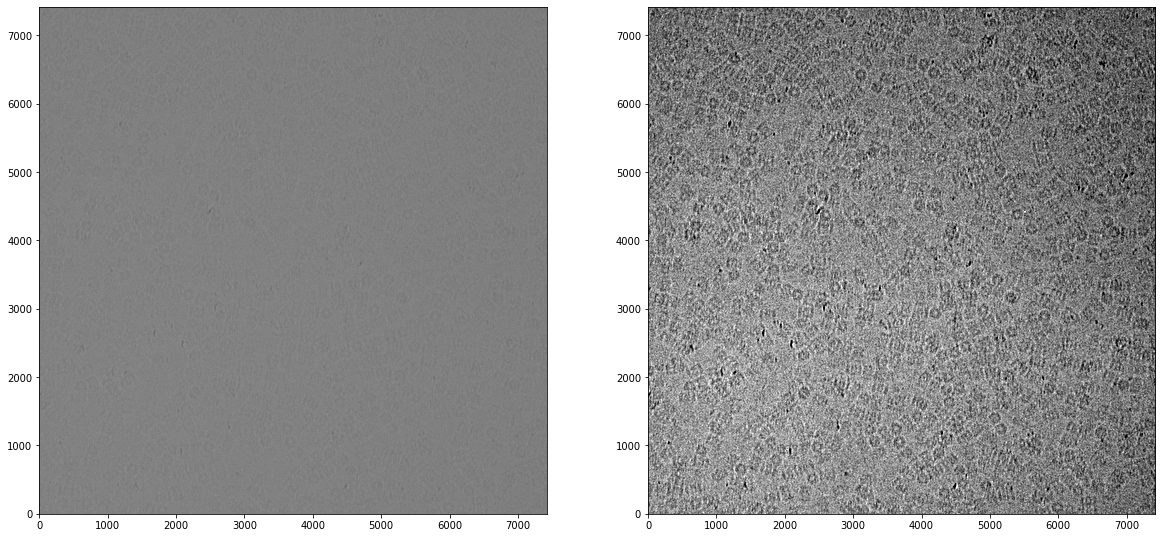

In [23]:
#Optionally fill me in to produce a low-pass filtered image at ~10A
#Step 1 - define the numpy array
#
#Step 2 - change the inner box to 1s
#
#Step 3 - apply the mask and visualize the resulting image in Fourier space and in real space
#

#######################################################################################
#SOLUTION#
#zoom_range = int(dim/10.0*ang_px)
#Step 1 - define the numpy array
#mask = np.zeros((dim,dim)) #note that we need to create a 2D mask to mask out both the real and imaginary components of the FT
#Step 2 - change the inner box to 1s
#window_low = int((dim-zoom_range)/2)
#window_high = int((dim+zoom_range)/2)
#mask[window_low:window_high,window_low:window_high] = 1
#plot_micrograph(mask[:,:], figsize=(5,5), axis=True)
#Step 3 - apply the mask and visualize the resulting image in Fourier space and in real space
#masked_fft = fft_cent*mask

#recovered_image_lowpass = inv_fft(masked_fft)
#f, axes = plt.subplots(1,2,figsize=(20,10))
#plot_micrograph(summed_micrograph, axis=True, ax=axes[0], crange=3)
#plot_micrograph(recovered_image_lowpass, axis=True, ax=axes[1], crange=3)
#######################################################################################

In practice, a more complex function such as a [Hamming window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows) is used to filter these images. We have implemented this function below and set it to a ~10A filter. Notice how the resulting image is still low pass filtered, but doesn't have the hard edges you see in the square filter we used above 

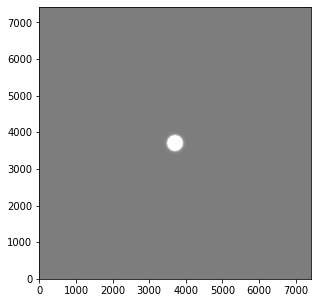

In [24]:
r = int(dim/10.0*ang_px)*2
ham = np.hamming(dim)[:,None] # 1D hamming
ham2d = np.sqrt(np.dot(ham, ham.T)) ** r # expand to 2D hamming
plot_micrograph(ham2d[:,:], figsize=(5,5), axis=True)

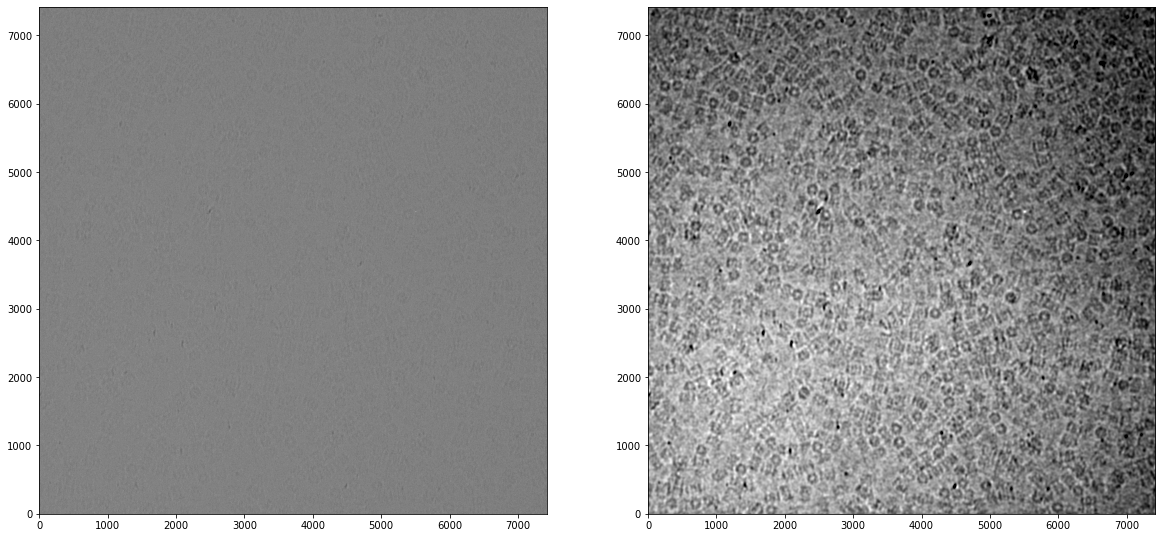

In [25]:
masked_fft = fft_cent*ham2d
del(ham2d)
recovered_image_lowpass = inv_fft(masked_fft)
del(masked_fft)
f, axes = plt.subplots(1,2,figsize=(20,10))
plot_micrograph(summed_micrograph, axis=True, ax=axes[0], crange=3)
plot_micrograph(recovered_image_lowpass, axis=True, ax=axes[1], crange=3)

Finally, it is worth noting that a similar filter is implemented as part of the scipy package. Syntax to apply that filter is below, and we will use this implementation going forward

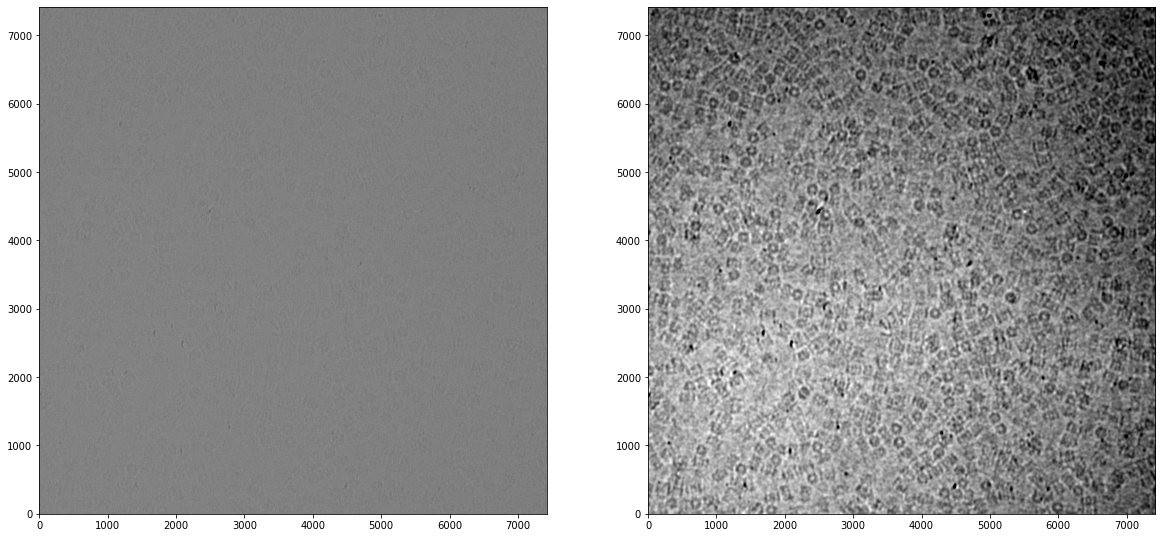

In [26]:
from scipy import ndimage
f, axes = plt.subplots(1,2,figsize=(20,10))
plot_micrograph(summed_micrograph, axis=True, ax=axes[0], crange=3)
plot_micrograph(ndimage.gaussian_filter(summed_micrograph, 15), axis=True, ax=axes[1], crange=3)

**Proceed to [part3](https://colab.research.google.com/drive/11av80E5bwmCs5Esatfn_KriQMQoXzAAJ) of the workshop**